Подключение библиотек

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend
import random

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from statsmodels.tsa.stattools import adfuller

Реализация функций для LPB

In [ ]:
# функция оценки acf
def wacf(x, lag_max=None):
    if lag_max is None:
        lag_max = len(x) - 1
    n = len(x)
    lag_max = min(lag_max, n - 1)
    if lag_max < 0:
        raise ValueError("'lag_max' must be at least 0")

    # стандартная оценка acf
    acfest = sm.tsa.acf(x, nlags=n, fft=False)

    # конусная оценка
    s = np.arange(1, n + 1)
    upper = 2 * np.sqrt(np.log10(n) / n)
    ac = np.abs(acfest)

    # находим l
    j = ac < upper
    l = 0
    k = 1
    N = len(j) - 4
    while l < 1 and k <= N:
        if np.all(j[(k-1):(k + 4)]):
            l = k
        else:
            k += 1

    if l > 0:
        acfest = acfest * kappa(s / l)

    # построим матрицу ковариации
    gamma = acfest
    s = len(gamma)
    Gamma = np.ones((s, s))
    d = np.subtract.outer(np.arange(s), np.arange(s))
    for i in range(1, s):
        Gamma[np.logical_or(d == i, d == -i)] = gamma[i]

    # находим собственные значенияя и векторы с помощью разложения
    eig_vals, eig_vecs = np.linalg.eig(Gamma)

    # сократим собственные значения
    d = np.maximum(eig_vals, 20 / n)

    # строим новую ковариационную матрицу
    Gamma2 = np.dot(np.dot(eig_vecs, np.diag(d)), eig_vecs.T)
    Gamma2 = Gamma2 / np.mean(d)

    # оцениваем новую ACF
    d = np.subtract.outer(np.arange(s), np.arange(s))
    for i in range(1, s):
        gamma[i] = np.mean(Gamma2[d == i])
    acfest = gamma

    return acfest

In [ ]:
# корневая функция
def kappa(x):
    k = np.zeros(len(x))
    x = np.abs(x)
    k[x <= 1] = 1
    k[np.logical_and(x > 1, x <= 2)] = 2 - x[np.logical_and(x > 1, x <= 2)]
    return k

In [ ]:
# функция Linear Process Bootstrap
def lpb(x, nsim=100):
    n = len(x)
    meanx = np.mean(x)
    y = x - meanx
    gamma = wacf(y, n-1)
    s = len(gamma)
    Gamma = np.ones((s, s))
    d = np.subtract.outer(np.arange(s), np.arange(s))
    for i in range(1, s):
        Gamma[np.logical_or(d == i, d == -i)] = gamma[i]
    L = np.linalg.cholesky(Gamma)
    W = np.linalg.solve(L, y)
    out = []
    for i in range(nsim):
      samples = random.choices(W, k=n)
      out.append(np.transpose(np.dot(L, samples) + meanx))

    return out

Реализация функций для беггинга

In [ ]:
# Алгоритм Бергмайра для составления выборок из временного ряда
def bergmeir(dataset, is_seasonal, number_of_bs):
  lam = stats.boxcox_normmax(dataset, brack=(0.0, 1.0))
  bc = boxcox(dataset, lam)
  if is_seasonal:
    stl = STL(bc)
    stl = stl.fit()
    seasonal, trend, remainder = stl.seasonal, stl.trend, stl.resid
  else:
    remainder = detrend(dataset)
    trend = dataset - remainder
  result = [dataset]
  remainder = lpb(remainder, number_of_bs)
  for x in remainder:
    if is_seasonal:
      restored = np.array(trend.values) + np.array(seasonal.values) + x
    else:
      restored = np.array(trend.values) + x
    restored = inv_boxcox(restored, lam)
    if np.isnan(np.sum(restored)): print("restored is nan")
    restored = pd.Series(data = restored, index=dataset.index)
    result.append(restored)

  return result

In [ ]:
# предсказание с помощью ETS
def ets_forecast(train, test, seasonal):
  if seasonal:
    model = ExponentialSmoothing(train, seasonal_periods=12, trend="add", seasonal='add')
  else:
    model = ExponentialSmoothing(train, trend="add")
  model_fit = model.fit()
  forecast = model_fit.forecast(len(test))

  # Получение значений информационных критериев
  residuals = model_fit.resid
  n = len(residuals)
  sigma2 = np.sum(residuals ** 2) / n
  log_likelihood = -n / 2 * np.log(2 * np.pi * sigma2) - n / 2
  aic = model_fit.aic
  aicc = model_fit.aicc
  bic = model_fit.bic

  # Вывод данных в консоль
  print("----------------------- Прогноз -----------------------")
  print(forecast)
  print("--------------- Информационные критерии ---------------")
  print("Log-likelihood:", log_likelihood)
  print("AIC:", aic)
  print("AICc:", aicc)
  print("BIC:", bic)
  print("-------------------------------------------------------")

  return forecast

In [ ]:
# предсказание с помощью ARIMA
def arima_forecast(train, test, seasonal):
  if seasonal:
    model = auto_arima(train, seasonal=True, m=12)
  else:
    model = auto_arima(train, seasonal=False, m=0)
  print(model)
  forecast = model.predict(len(test))

  # Получение значений информационных критериев
  log_likelihood = model.arima_res_.llf
  aic = model.aic()
  aicc = model.aicc()
  bic = model.bic()

  # Вывод данных в консоль
  print("----------------------- Прогноз -----------------------")
  print(forecast)
  print("--------------- Информационные критерии ---------------")
  print("Log-likelihood:", log_likelihood)
  print("AIC:", aic)
  print("AICc:", aicc)
  print("BIC:", bic)
  print("-------------------------------------------------------")
  return forecast

In [ ]:
# предсказание с помощью бэггинга
def bagging_forecast(train, test, model_name, seasonal):
  forecasts = []
  if model_name == "arima":
    arima = auto_arima(train[0], seasonal=True, m=12)
  # получаем предсказания для псевдовыборок
  for i, sample in enumerate(train):
    if model_name == "ets":
      fc = ets_forecast(train[i], test, seasonal)
    if model_name == "arima":
      fc = arima_forecast(train[i], test, seasonal)
    forecasts.append(fc)
    #print(f"forecast for train[{i}]:", fc)
  return np.mean(forecasts, axis = 0)

In [ ]:
# отрисовка
def printer(t, p):
  print("Pred: \t", p)
  print("Test: \t", t.values)
  RMSE = mean_squared_error(t, p, squared = False)
  print('RMSE:', RMSE)
  MAE = mean_absolute_error(t, p)
  print('MAE:', MAE)
  plt.figure(figsize=(10,4))
  plt.scatter(t.index, p, color = 'red')
  plt.plot(t.index, p, color = 'red', alpha = 0.5)
  plt.scatter(t.index, t, color = 'green')
  plt.plot(t.index, t, color = 'green', alpha = 0.5)
  plt.grid()
  plt.show()

In [ ]:
# Проверка ряда на стационарность
def test_stationarity(timeseries):
    # Определение статистики ряда
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Визуализация скользящего среднего и стандартного отклонения
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Тест Дики-Фуллера
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Проверка стационарности по p-value
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

Для загрузки датасетов

In [ ]:
class SophistHSE:
    def __init__(self):
        self.url = 'http://sophist.hse.ru/hse/1/tables/'

    #Transform str index to datetime index
    def __time_to_datetime__(self, df):
        current_year = df.index[0].split()[0]
        new_index = []
        for index, row in df.iterrows():
            lst = index.split()
            if len(lst) == 2:
                current_year = lst[0]
                new_index.append(pd.to_datetime(index))
            else:
                new_index.append(pd.to_datetime(current_year + ' ' + lst[0]))

        df.index = new_index
        return df

    #Parse Table
    def get_table(self, table):
        df = pd.read_html(self.url + table + '.htm', index_col = 0, decimal = ',', thousands = None,  na_values = '&nbsp')[0]
        df.rename(columns = df.iloc[0], inplace=True)
        df = df[df.index.notna()]
        df = df.drop(index = ['T'])
        df = self.__time_to_datetime__(df).astype(float)
        return df

In [ ]:
    def drop_crisis_years(data, freq = 'MS'):
        data = data[data.index.year >= 2000]
        data = data[data.index.year != 2008]
        data = data[data.index.year != 2014]
        data = data[data.index.year <  2022]
        data = data.dropna()

        idx = pd.date_range(data.index[0], periods = len(data.values), freq = freq)

        return pd.Series(data.values, index = idx)

# Индекс реального объема сельскохозяйственного производства

In [ ]:
HSE = SophistHSE()
table = 'AGR_M_I' #Put here name of dataset
df = HSE.get_table(table)

In [ ]:
df

,AGR_M_DIRI,AGR_M_DIRI_SA
1993-01-01,100.0,271.7
1993-02-01,106.8,269.9
1993-03-01,136.2,267.5
1993-04-01,153.4,264.4
1993-05-01,177.1,260.8
...,...,...
2023-10-01,822.3,345.1
2023-11-01,363.5,345.8
2023-12-01,211.2,347.2
2024-01-01,97.8,349.1


In [ ]:
df = drop_crisis_years(df['AGR_M_DIRI'])

In [ ]:
df[df.index.year==2000]

2000-01-01     68.8
2000-02-01     73.0
2000-03-01     97.8
2000-04-01    112.6
2000-05-01    130.8
2000-06-01    158.6
2000-07-01    200.0
2000-08-01    365.2
2000-09-01    503.8
2000-10-01    266.9
2000-11-01    163.7
2000-12-01    100.3
Freq: MS, dtype: float64

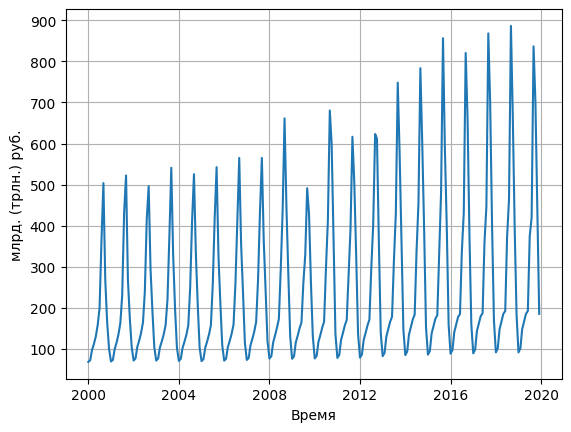

In [ ]:
plt.plot(df)

# Добавьте пояснения к осям
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.grid(True)
# Отобразите график
plt.show()

In [ ]:
# разбиваем на обучающую и тестовую выборки
train = df.head(df.size - 12)
test = df.tail(12)

In [ ]:
train

2000-01-01     68.8
2000-02-01     73.0
2000-03-01     97.8
2000-04-01    112.6
2000-05-01    130.8
              ...  
2018-08-01    464.4
2018-09-01    886.0
2018-10-01    666.3
2018-11-01    389.8
2018-12-01    182.0
Freq: MS, Length: 228, dtype: float64

In [ ]:
test

2019-01-01     91.9
2019-02-01    102.2
2019-03-01    148.3
2019-04-01    167.1
2019-05-01    185.5
2019-06-01    192.8
2019-07-01    374.6
2019-08-01    420.2
2019-09-01    836.3
2019-10-01    700.8
2019-11-01    440.1
2019-12-01    185.7
Freq: MS, dtype: float64

<Figure size 640x480 with 0 Axes>

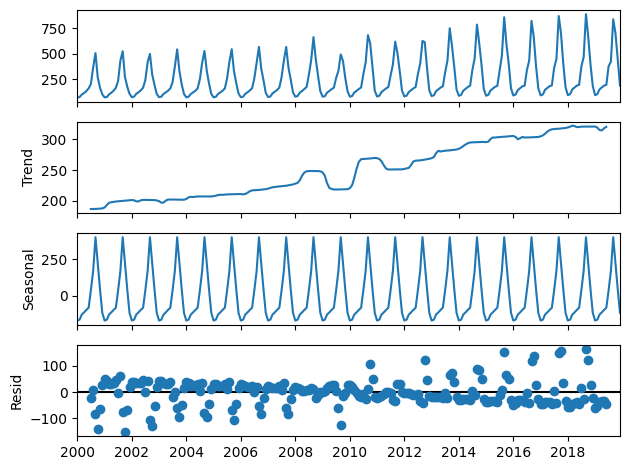

In [ ]:
result = seasonal_decompose(df, model='additive', period=12)
plt.figure()
result.plot()
plt.gcf().suptitle('')
plt.show()

In [ ]:
bs = bergmeir(train, is_seasonal=True, number_of_bs=5)

In [ ]:
print('ETS ORIGINAL:')
ets_pred = ets_forecast(train, test, seasonal=True)
print('LPB (ETS):')
bagging_ets_forecast = bagging_forecast(bs, test, "ets", seasonal=True)

ETS ORIGINAL:
----------------------- Прогноз -----------------------
2019-01-01     93.720769
2019-02-01    106.633594
2019-03-01    154.900351
2019-04-01    176.335219
2019-05-01    197.104619
2019-06-01    206.866887
2019-07-01    384.337263
2019-08-01    475.058859
2019-09-01    892.844788
2019-10-01    683.362199
2019-11-01    404.186793
2019-12-01    173.948971
Freq: MS, dtype: float64
--------------- Информационные критерии ---------------
Log-likelihood: -1067.9820902495817
AIC: 1520.9282093578324
AICc: 1524.2009366305597
BIC: 1575.7977394211034
-------------------------------------------------------
LPB (ETS):
----------------------- Прогноз -----------------------
2019-01-01     93.720769
2019-02-01    106.633594
2019-03-01    154.900351
2019-04-01    176.335219
2019-05-01    197.104619
2019-06-01    206.866887
2019-07-01    384.337263
2019-08-01    475.058859
2019-09-01    892.844788
2019-10-01    683.362199
2019-11-01    404.186793
2019-12-01    173.948971
Freq: MS, dtype: 

In [ ]:
print('ARIMA ORIGINAL:')
arima_pred = arima_forecast(bs[0], test, seasonal=True)
print('LPB (ARIMA):')
bagging_arima_forecast = bagging_forecast(bs, test, "arima", seasonal=True)

ARIMA ORIGINAL:
 ARIMA(1,0,0)(1,1,0)[12] intercept
----------------------- Прогноз -----------------------
2019-01-01    104.568365
2019-02-01    112.674530
2019-03-01    157.358854
2019-04-01    175.914072
2019-05-01    193.946333
2019-06-01    201.069980
2019-07-01    376.941112
2019-08-01    467.029979
2019-09-01    888.486681
2019-10-01    692.055532
2019-11-01    404.009577
2019-12-01    186.900262
Freq: MS, dtype: float64
--------------- Информационные критерии ---------------
Log-likelihood: -993.4091861992799
AIC: 1994.8183723985599
AICc: 1994.9977445958693
BIC: 2008.3194860292965
-------------------------------------------------------
LPB (ARIMA):
 ARIMA(1,0,0)(1,1,0)[12] intercept
----------------------- Прогноз -----------------------
2019-01-01    104.568365
2019-02-01    112.674530
2019-03-01    157.358854
2019-04-01    175.914072
2019-05-01    193.946333
2019-06-01    201.069980
2019-07-01    376.941112
2019-08-01    467.029979
2019-09-01    888.486681
2019-10-01    692.0

Pred: 	 2019-01-01     93.720769
2019-02-01    106.633594
2019-03-01    154.900351
2019-04-01    176.335219
2019-05-01    197.104619
2019-06-01    206.866887
2019-07-01    384.337263
2019-08-01    475.058859
2019-09-01    892.844788
2019-10-01    683.362199
2019-11-01    404.186793
2019-12-01    173.948971
Freq: MS, dtype: float64
Test: 	 [ 91.9 102.2 148.3 167.1 185.5 192.8 374.6 420.2 836.3 700.8 440.1 185.7]
RMSE: 26.6425632801018
MAE: 19.500365518621184


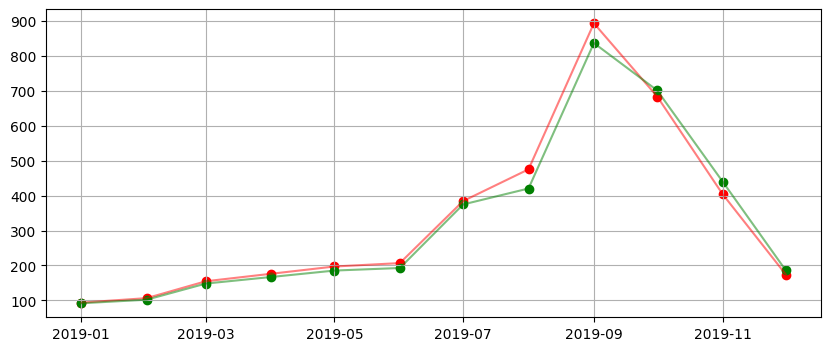

In [ ]:
printer(test, ets_pred)

Pred: 	 [ 99.10775622 110.40521927 157.24713726 177.9997274  195.4219768
 201.45062004 377.44581067 466.70858157 890.72033713 690.40822598
 400.72840383 181.30502193]
Test: 	 [ 91.9 102.2 148.3 167.1 185.5 192.8 374.6 420.2 836.3 700.8 440.1 185.7]
RMSE: 24.667047557942617
MAE: 17.647126219988397


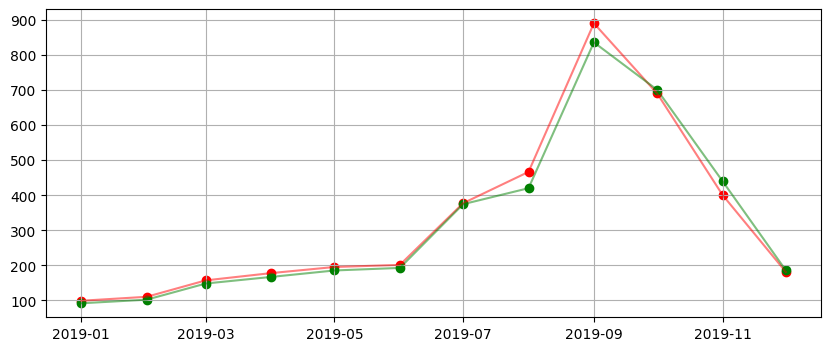

In [ ]:
printer(test, bagging_ets_forecast)

Pred: 	 2019-01-01    104.568365
2019-02-01    112.674530
2019-03-01    157.358854
2019-04-01    175.914072
2019-05-01    193.946333
2019-06-01    201.069980
2019-07-01    376.941112
2019-08-01    467.029979
2019-09-01    888.486681
2019-10-01    692.055532
2019-11-01    404.009577
2019-12-01    186.900262
Freq: MS, dtype: float64
Test: 	 [ 91.9 102.2 148.3 167.1 185.5 192.8 374.6 420.2 836.3 700.8 440.1 185.7]
RMSE: 23.93061047395889
MAE: 17.093754909333935


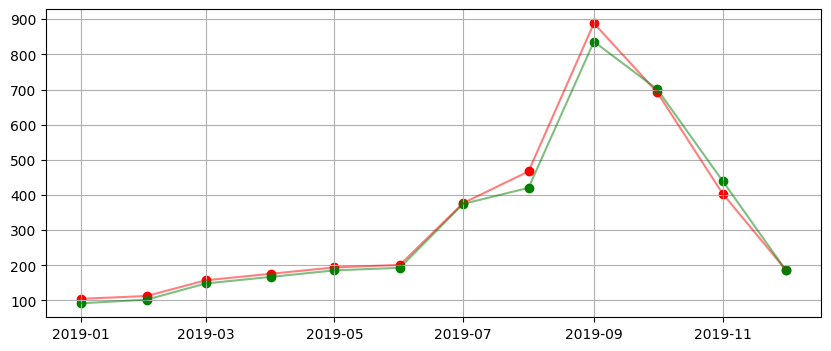

In [ ]:
printer(test, arima_pred)

Pred: 	 [102.20020435 108.97548638 154.89231671 175.07771438 191.51415947
 196.21079372 374.93038479 463.23578475 903.25980479 703.93183617
 404.25165232 186.32835983]
Test: 	 [ 91.9 102.2 148.3 167.1 185.5 192.8 374.6 420.2 836.3 700.8 440.1 185.7]
RMSE: 25.719671889848627
MAE: 15.91709941823435


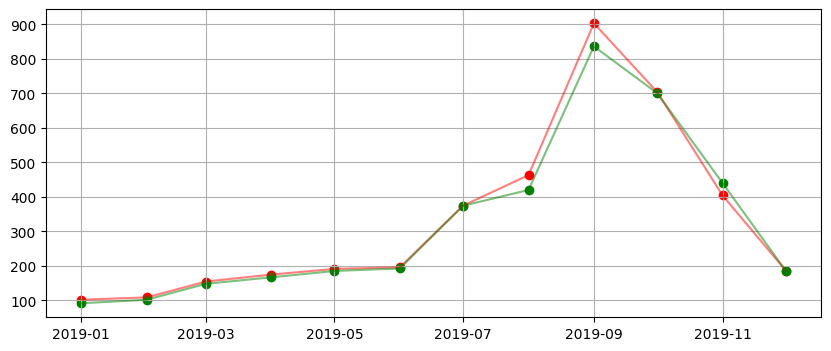

In [ ]:
printer(test, bagging_arima_forecast)

Pred: 	 [100.65398028 109.69035283 156.06972699 176.53872089 193.46806813
 198.83070688 376.18809773 464.97218316 896.99007096 697.17003107
 402.49002807 183.81669088]
Test: 	 [ 91.9 102.2 148.3 167.1 185.5 192.8 374.6 420.2 836.3 700.8 440.1 185.7]
RMSE: 25.006072378392144
MAE: 16.468763152297694


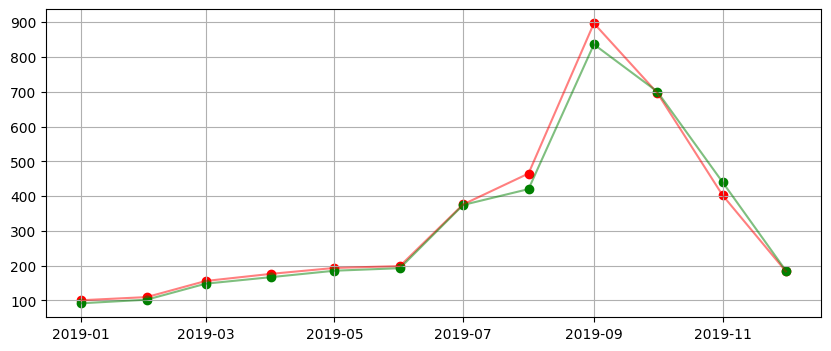

In [ ]:
bagging_res = (bagging_arima_forecast + bagging_ets_forecast) / 2
printer(test, bagging_res)

# Индекс денежного дохода населения

In [ ]:
HSE = SophistHSE()
table2 = 'HHI_M_I' #Put here name of dataset
df2 = HSE.get_table(table2)

In [ ]:
df2

,HHI_M_DIRI,HHI_M_DIRI_SA,HHI_M
1992-12-01,100.0,85.4,NaN
1993-01-01,73.0,85.9,10.0
1993-02-01,79.6,86.5,14.0
1993-03-01,85.9,87.1,18.0
1993-04-01,85.0,87.9,21.0
...,...,...,...
2018-09-01,184.1,187.5,31698.0
2018-10-01,190.9,187.9,32962.0
2018-11-01,183.3,188.6,32282.0
2018-12-01,279.1,189.6,47673.0


In [ ]:
df2 = drop_crisis_years(df2['HHI_M_DIRI'])

In [ ]:
df2

2000-01-01     60.2
2000-02-01     71.3
2000-03-01     77.2
2000-04-01     78.3
2000-05-01     75.9
              ...  
2016-09-01    184.1
2016-10-01    190.9
2016-11-01    183.3
2016-12-01    279.1
2017-01-01    139.6
Freq: MS, Length: 205, dtype: float64

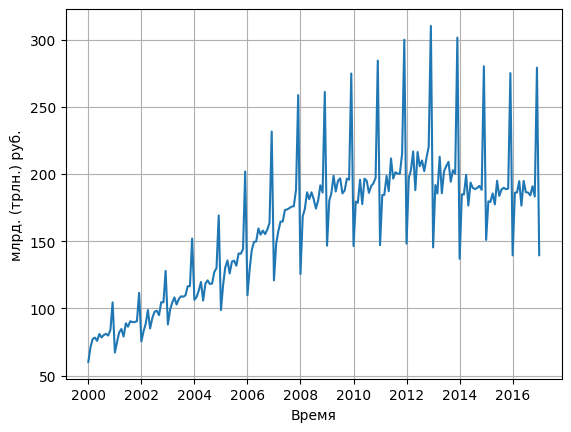

In [ ]:
plt.plot(df2)

# Добавьте пояснения к осям
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.grid(True)
# Отобразите график
plt.show()

In [ ]:
# разбиваем на обучающую и тестовую выборки
train2 = df2.head(df2.size - 12)
test2 = df2.tail(12)

In [ ]:
train2

2000-01-01     60.2
2000-02-01     71.3
2000-03-01     77.2
2000-04-01     78.3
2000-05-01     75.9
              ...  
2015-09-01    189.8
2015-10-01    188.7
2015-11-01    189.2
2015-12-01    275.1
2016-01-01    139.5
Freq: MS, Length: 193, dtype: float64

In [ ]:
test2

2016-02-01    186.1
2016-03-01    186.3
2016-04-01    194.7
2016-05-01    176.5
2016-06-01    194.9
2016-07-01    186.5
2016-08-01    186.2
2016-09-01    184.1
2016-10-01    190.9
2016-11-01    183.3
2016-12-01    279.1
2017-01-01    139.6
Freq: MS, dtype: float64

<Figure size 640x480 with 0 Axes>

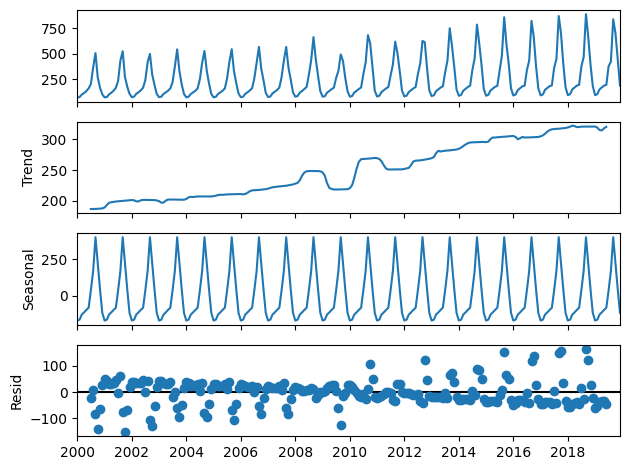

In [ ]:
result2 = seasonal_decompose(df2, model='additive', period=12)
plt.figure()
result.plot()
plt.gcf().suptitle('')
plt.show()

In [ ]:
bs2 = bergmeir(train2, is_seasonal=True, number_of_bs=5)
print('ETS ORIGINAL:')
ets_pred_2 = ets_forecast(train2, test2, seasonal=True)
print('LPB (ETS):')
bagging_ets_forecast_2 = bagging_forecast(bs2, test2, "ets", seasonal=True)

ETS ORIGINAL:
----------------------- Прогноз -----------------------
2016-02-01    173.785628
2016-03-01    172.662489
2016-04-01    181.104463
2016-05-01    170.506784
2016-06-01    186.864519
2016-07-01    176.811517
2016-08-01    181.290570
2016-09-01    181.898095
2016-10-01    181.185021
2016-11-01    181.245045
2016-12-01    269.084157
2017-01-01    139.203825
Freq: MS, dtype: float64
--------------- Информационные критерии ---------------
Log-likelihood: -634.5337559613125
AIC: 753.3572381056211
AICc: 757.2882725883798
BIC: 805.5602811280993
-------------------------------------------------------
LPB (ETS):
----------------------- Прогноз -----------------------
2016-02-01    173.785628
2016-03-01    172.662489
2016-04-01    181.104463
2016-05-01    170.506784
2016-06-01    186.864519
2016-07-01    176.811517
2016-08-01    181.290570
2016-09-01    181.898095
2016-10-01    181.185021
2016-11-01    181.245045
2016-12-01    269.084157
2017-01-01    139.203825
Freq: MS, dtype: floa

In [ ]:
print('ARIMA ORIGINAL:')
arima_pred_2 = arima_forecast(bs2[0], test2, seasonal=True)
print('LPB (ARIMA):')
bagging_arima_forecast_2 = bagging_forecast(bs2, test2, "arima", seasonal=True)

ARIMA ORIGINAL:
 ARIMA(0,1,1)(0,1,0)[12]          
----------------------- Прогноз -----------------------
2016-02-01    174.725758
2016-03-01    174.225758
2016-04-01    180.625758
2016-05-01    172.425758
2016-06-01    190.025758
2016-07-01    178.725758
2016-08-01    183.525758
2016-09-01    184.825758
2016-10-01    183.725758
2016-11-01    184.225758
2016-12-01    270.125758
2017-01-01    134.525758
Freq: MS, dtype: float64
--------------- Информационные критерии ---------------
Log-likelihood: -595.721620931301
AIC: 1195.443241862602
AICc: 1195.5063997573388
BIC: 1201.8291555643825
-------------------------------------------------------
LPB (ARIMA):
 ARIMA(0,1,1)(0,1,0)[12]          
----------------------- Прогноз -----------------------
2016-02-01    174.725758
2016-03-01    174.225758
2016-04-01    180.625758
2016-05-01    172.425758
2016-06-01    190.025758
2016-07-01    178.725758
2016-08-01    183.525758
2016-09-01    184.825758
2016-10-01    183.725758
2016-11-01    184.225

Pred: 	 2016-02-01    173.785628
2016-03-01    172.662489
2016-04-01    181.104463
2016-05-01    170.506784
2016-06-01    186.864519
2016-07-01    176.811517
2016-08-01    181.290570
2016-09-01    181.898095
2016-10-01    181.185021
2016-11-01    181.245045
2016-12-01    269.084157
2017-01-01    139.203825
Freq: MS, dtype: float64
Test: 	 [186.1 186.3 194.7 176.5 194.9 186.5 186.2 184.1 190.9 183.3 279.1 139.6]
RMSE: 8.87340111088211
MAE: 7.713157121288501


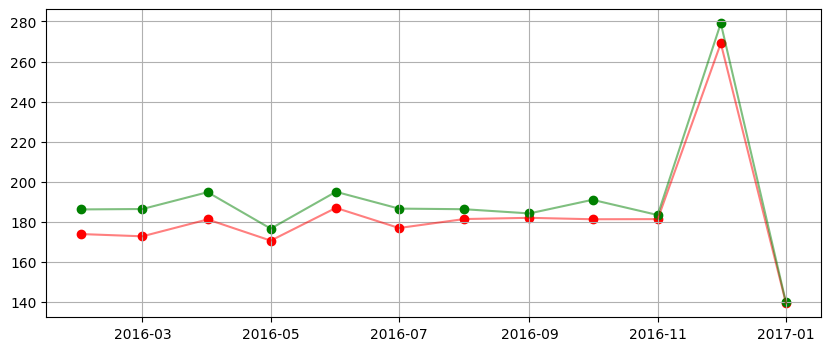

In [ ]:
printer(test2, ets_pred_2)

Pred: 	 [175.36750613 173.76661817 182.73587753 171.78277525 187.75129781
 181.86187327 185.8551734  182.73385234 184.14647861 182.37321831
 274.09845967 134.91361408]
Test: 	 [186.1 186.3 194.7 176.5 194.9 186.5 186.2 184.1 190.9 183.3 279.1 139.6]
RMSE: 7.104649546588851
MAE: 5.901104619234502


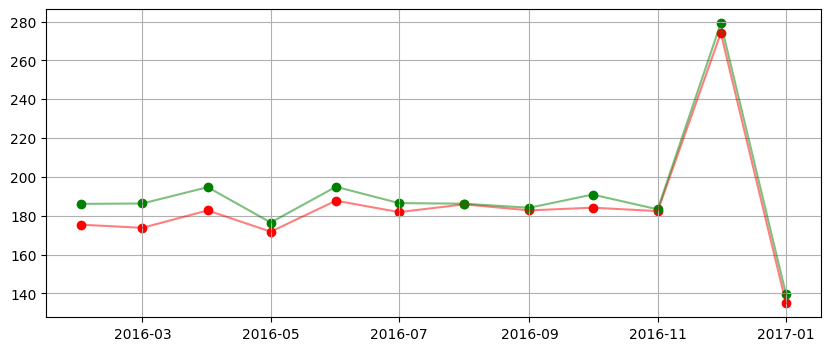

In [ ]:
printer(test2, bagging_ets_forecast_2)

Pred: 	 2016-02-01    174.725758
2016-03-01    174.225758
2016-04-01    180.625758
2016-05-01    172.425758
2016-06-01    190.025758
2016-07-01    178.725758
2016-08-01    183.525758
2016-09-01    184.825758
2016-10-01    183.725758
2016-11-01    184.225758
2016-12-01    270.125758
2017-01-01    134.525758
Freq: MS, dtype: float64
Test: 	 [186.1 186.3 194.7 176.5 194.9 186.5 186.2 184.1 190.9 183.3 279.1 139.6]
RMSE: 7.854571645192503
MAE: 6.649494735776308


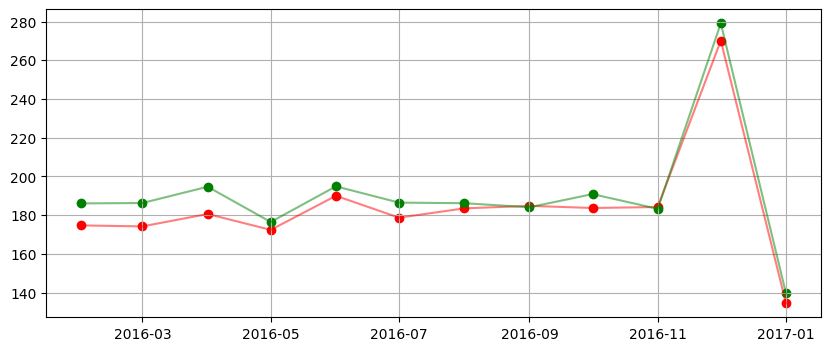

In [ ]:
printer(test2, arima_pred_2)

Pred: 	 [176.28834044 174.66336943 182.52095946 172.18847957 188.25065784
 182.30819872 185.9005377  183.50090386 184.96500304 183.03254715
 274.59144027 137.50431653]
Test: 	 [186.1 186.3 194.7 176.5 194.9 186.5 186.2 184.1 190.9 183.3 279.1 139.6]
RMSE: 6.5881606835335145
MAE: 5.20710383351998


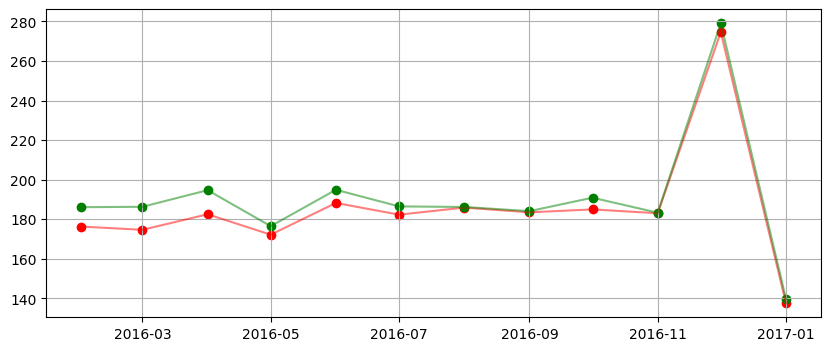

In [ ]:
printer(test2, bagging_arima_forecast_2)

Pred: 	 [175.82792329 174.2149938  182.62841849 171.98562741 188.00097782
 182.08503599 185.87785555 183.1173781  184.55574082 182.70288273
 274.34494997 136.2089653 ]
Test: 	 [186.1 186.3 194.7 176.5 194.9 186.5 186.2 184.1 190.9 183.3 279.1 139.6]
RMSE: 6.8345879080466325
MAE: 5.554104226377231


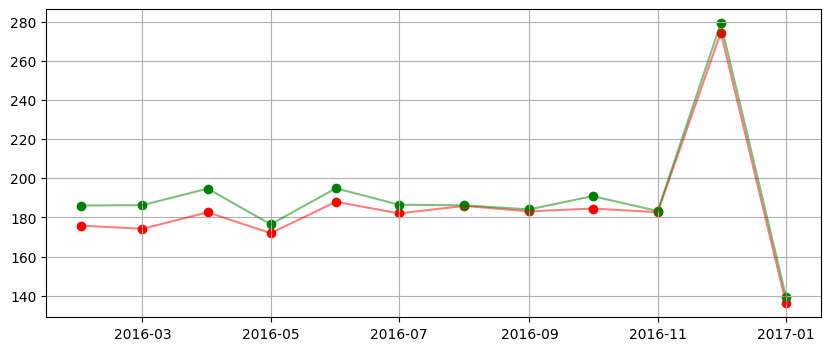

In [ ]:
bagging_res_2 = (bagging_arima_forecast_2 + bagging_ets_forecast_2) / 2
printer(test2, bagging_res_2)